In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.tree import export_graphviz
import sklearn.metrics as metrics
from sklearn.feature_selection import SequentialFeatureSelector, RFECV
import re
from graphviz import render
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from scipy import interpolate
from sklearn.metrics import accuracy_score
from matplotlib.ticker import FormatStrFormatter

from matplotlib.colors import LinearSegmentedColormap

matplotlib.style.use('ggplot')

In [2]:
# function to remove assays and medias with less than 4 occurrences

def agg_size_nosort(df):
    counts_assay = df.groupby("assay", sort=False)["assay"].transform('size')
    counts_media = df.groupby("media", sort=False)["media"].transform('size')
    mask = (counts_assay > 3) & (counts_media > 3)
    return df[mask]

# function to plot data in bins
def plot_bar_bin(series, bins, img_name):
    '''
    plot an histogram with ranges of data as columns
    :param series: series of the feature to plot
    :param bins: a list with the limit values of the bins
    :param img_name: name of the saved figure
    :return: histogram of data points in each bin
    '''
    # general bar plots with 6 bins
    to_plot = series.dropna(axis=0)
    color = cm.rainbow(np.linspace(0, 1, len(bins) - 1))
    fig, ax = plt.subplots()
    hist, bin_edges = np.histogram(to_plot, bins)
    ax.set_ylim(0, 50)
    #ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Number of data points')
    ax.set_xlabel('BMDL range [ug/mL]')
    rec = ax.bar(range(len(hist)), hist, width=0.8, align='center', tick_label=
    ['{} - {}'.format(bins[i], bins[i + 1]) for i, j in enumerate(hist)], color=color)
    plt.xticks(rotation=45)
    autolabel(rec, ax)
    plt.tight_layout()
    plt.savefig(f'{img_name}.png')
    plt.show()

def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 1.05 * height,
               s= '%d' % int(height),
                ha='center', va='bottom')


#Function to print positive feature importance based on the Linear SVC coefficients, per class

def print_top10(feature_names, clf, x_name, class_labels):
    """Prints features with the highest coefficient values, per class"""
    for i, class_label in enumerate(class_labels):
        coeff = clf.coef_[i]
        ordered_coef = [x for x,_ in sorted(zip(coeff,feature_names), key=lambda sublist: abs(sublist[0]))[::-1]]
        ordered_names = [y for _,y in sorted(zip(coeff,feature_names), key=lambda sublist: abs(sublist[0]))[::-1]]
        ordered_coef_pos = [x for x in ordered_coef[0:10]]
        ordered_names_pos = ordered_names[:len(ordered_coef_pos)]

        fig, ax = plt.subplots()
        plt.barh(range(len(ordered_names_pos)), ordered_coef_pos[::-1], align='center')
        plt.yticks(range(len(ordered_names_pos)), ordered_names_pos[::-1])
        plt.axvline(0)
        plt.text(0,-1.5,'0.0', size=12)
        ax.set_xticklabels([])
        plt.title(f'Feature importance for class {class_label}', fontsize=14)
        plt.tight_layout()
        plt.savefig(f'Graphene//New_plots//BMDL LinearSVC viab 3class coeff2 {x_name} {i}.pdf')
        plt.show()


# Function to plot confusion matrix

def confusion_matrix(matrix, tick_names, file_name, data_set_name):
        # Plot confusion matrix
        figure = plt.figure()
        ax = plt.subplot()
        cmap2 = LinearSegmentedColormap.from_list('', ['#aaddee', '#000077'])
        im = ax.imshow(matrix, cmap=cmap2, interpolation='nearest')
        #tick_marks = [0,1,2,3]
        tick_marks=[0, 1, 2]
        ax.xaxis.tick_top()
        ax.yaxis.set_label_position("right")
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(tick_names)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        plt.setp(ax.get_xticklabels(),  fontsize=12)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(tick_names)
        plt.setp(ax.get_yticklabels(), fontsize=12, rotation=90,ha='center', rotation_mode='anchor' )
        #ax.set_ylim(-0.0005, 2.5)
        # change font color to white to be visible against darkest colors
        for (i, j), z in np.ndenumerate(matrix):
            if z > 8:
                fontcolor = 'white'
            else:
                fontcolor = 'black'
            ax.text(j, i, str(int(z)), ha='center', va='center', color= fontcolor, size=12)
        fig.colorbar(im, ax=ax)
        ax.grid(None)
        plt.tight_layout()
        plt.savefig(f'{file_name}_{data_set_name}.pdf', dpi=400)
        plt.savefig(f'{file_name}_{data_set_name}.png', dpi=400)
        plt.show()

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum()
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int),
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(),
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(),
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"],
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interpolate(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

def specificity(conf):
    #row 1
    tn = conf[1,1] + conf[1,2] + conf[2,1] + conf[2,2]
    fp = conf[2,0] + conf[1,0]
    print(f'specificity first row = {tn/(tn+fp)}')
    #row 2
    tn = conf[2,0] + conf[2,2] + conf[0,0] + conf[0,2]
    fp = conf[2,1] + conf[0,1]
    print(f'specificity second row = {tn/(tn+fp)}')
    #row 3
    tn = conf[0,0] + conf[0,1] + conf[1,0] + conf[1,1]
    fp = conf[0,2] + conf[1,2]
    print(f'specificity third row = {tn/(tn+fp)}')


In [3]:
################################
#   LOADING DATA
#################################
df_v = pd.read_csv('Graphene/Graphene_BMD_UPDATED_no_outliers.csv')
df_v.describe()



,BMD,BMDL,BMDH,bmd_id,ID,media_viscosity,media_density,media_temperature,layer,z_pot,time,BMD_range
count,94.000000,94.000000,94.000000,94.000000,94.000000,15.000000,15.000000,94.0,74.000000,74.000000,94.000000,94.000000
mean,85.151612,64.963161,114.943479,5475.553191,404.148936,0.001196,1.027368,37.0,2.398649,-21.165757,37.978723,49.980318
std,105.383795,71.790466,162.108284,1792.218902,239.524841,0.000085,0.004694,0.0,1.947917,20.714600,50.728876,111.790778
min,0.083870,0.021400,0.088000,1018.000000,1.000000,0.000890,1.010400,37.0,1.000000,-76.000000,2.000000,0.008100
25%,17.637500,12.925000,23.300000,5031.750000,215.500000,0.001217,1.028580,37.0,1.000000,-37.225000,24.000000,3.375000
50%,42.565000,31.900000,52.100000,6077.500000,403.000000,0.001217,1.028580,37.0,1.500000,-11.370000,24.000000,11.500000
75%,121.875000,111.500000,140.750000,6138.750000,631.000000,0.001217,1.028580,37.0,3.500000,-6.900000,48.000000,34.000000
max,539.500000,274.000000,1040.000000,9057.000000,787.000000,0.001217,1.028580,37.0,8.000000,0.036000,240.000000,845.000000


In [5]:
################################
#   PREPARING DATA FOR ANALYSIS
#################################

df_v[['new_name', 'species']] = df_v[['new_name', 'species']].applymap(lambda x: x.strip())
df_v['func'] = df_v['func'].fillna(0)

# keep only alpah numeric characters in media column
df_v['media'] = df_v['media'].apply(lambda row: re.sub(r'\W+', '', row))

df_v['assay'] = df_v['assay'].apply(lambda row: row.replace('viability_', ''))

print(f'Before removing less than 4 assay and media, size = {len(df_v)}')

df_v = agg_size_nosort(df_v)
print(f'After removing less than 4 assay and media, size = {len(df_v)}')


Before removing less than 4 assay and media, size = 76
After removing less than 4 assay and media, size = 76


In [12]:
report

[1.0    29
 0.0    24
 2.0    23
 Name: BMDL_class, dtype: int64,
 Graphene oxide    43
 rGO               22
 Graphene          11
 Name: Substance, dtype: int64,
 S    56
 M    11
 L     9
 Name: size_class, dtype: int64,
 24     32
 48     19
 6      14
 240     5
 3       4
 72      2
 Name: time, dtype: int64,
 BEAS- 2B    32
 A549        27
 THP-1       12
 J774.A1      5
 Name: cell_type, dtype: int64,
 mtt        45
 wst         8
 ldh         8
 cfa         5
 ez_cyto     5
 pi          5
 Name: assay, dtype: int64,
 0           53
 Fe3O4       10
 hydrated     4
 NH2          3
 COOH         2
 PEG          2
 PAM          1
 PAA          1
 Name: func, dtype: int64,
 1.0    23
 3.5    18
 1.5    12
 8.0     4
 6.0     2
 2.0     2
 Name: layer, dtype: int64,
 -6.900     10
 -13.700     9
 -9.460      8
 -11.370     4
  0.036      1
 -73.000     1
 -5.500      1
 -7.500      1
 -51.700     1
 -18.500     1
 -76.000     1
 -64.000     1
 -68.000     1
 -37.000     1
 -63.000  

In [ ]:
############################################
## SUPERVISED CLASSIFICATION
############################################

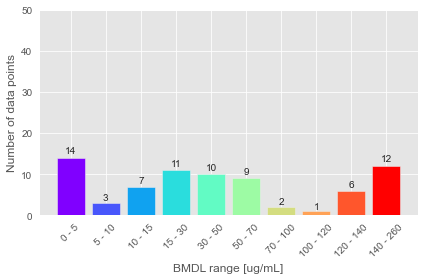

In [8]:
bins = [0, 5, 10, 15, 30, 50, 70, 100, 120, 140, 260]
plot_bar_bin(df_v['BMDL'], bins, 'BMDL distribution - viability')

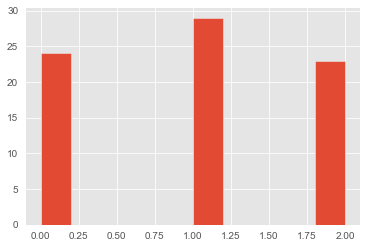

In [9]:
# Define BMDL classes
df_v['BMDL_class'] = np.nan

# 4 classes
'''
df_v.loc[df_v.BMDL < 15, 'BMDL_class'] = 0
df_v.loc[(df_v.BMDL >= 15) & (df_v.BMDL < 35), 'BMDL_class'] = 1
df_v.loc[(df_v.BMDL >= 35) & (df_v.BMDL < 100), 'BMDL_class'] = 2
df_v.loc[df_v.BMDL >= 100, 'BMDL_class'] = 3
'''
# 3 classes
df_v.loc[df_v.BMDL < 15, 'BMDL_class'] = 0
df_v.loc[(df_v.BMDL >= 15) & (df_v.BMDL < 60), 'BMDL_class'] = 1
df_v.loc[df_v.BMDL >= 60, 'BMDL_class'] = 2

# Plot distribution of data in the classes
fig = plt.figure()
plt.hist(df_v.BMDL_class)
plt.show()

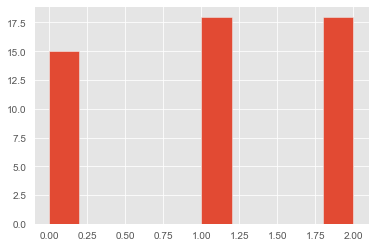

In [13]:
# Data set 1

sc = df_v[['BMDL_class', 'Substance', 'size_class', 'time', 'cell_type', 'assay','func', 'layer', 'z_pot', 'media',
           'cell_species','cell_type_general', 'species']].copy()
report = []
for colname in sc.columns:
    report.append(sc[colname].value_counts())
with open("report_occurrencies.txt", 'w') as output:
    for row in report:
        output.write(str(row) + '\n')
description = sc.describe()
description.to_csv('Report_data_set_description.csv')

sc.dropna(axis=0, inplace=True)
sc.reset_index(drop=True, inplace=True)
# categorical variables encoding
enc_size = {'S':1, 'M':2, 'L':3}
sc['size_class'] = sc['size_class'].apply(lambda row: enc_size[row])
sc = pd.get_dummies(sc, columns=['Substance',  'cell_type', 'cell_species', 'cell_type_general', 'species' , 'assay',
                                 'media', 'func'], drop_first=True)

y_1 = sc['BMDL_class']
x_source_1 = sc.drop(labels='BMDL_class', axis=1)

# plot distribution of dependent variable
fig = plt.figure()
plt.hist(y_1)
plt.show()


In [112]:
sc.describe()

,analysis,BMD,BMDL,BMDH,bmd_id,ID,author_year,link,Substance,type,...,time,cell_type,cell_type_general,species,endotox,assay,new_name,BMD_range,cell_species,BMDL_class
0,Graphene_4070_dose_viability_pi.txt,59.93000,51.8000,68.400,4070,358,Mittal et all 2016,https://www.nature.com/articles/srep39548,Graphene oxide,GO,...,24,A549,epithelial,human,NO,pi,Graphene oxide,16.6000,epithelial_human,1.0
2,Graphene_2013_dose_cfa.txt,0.08387,0.0799,0.088,2013,95,Chaterje N 2015,https://pubmed.ncbi.nlm.nih.gov/26602558/,Graphene,GNPs,...,240,BEAS- 2B,epithelial,human,NaN,cfa,Graphene,0.0081,epithelial_human,0.0
3,Graphene_2014_dose_cfa.txt,10.00000,9.8000,10.200,2014,101,Chaterje N 2015,https://pubmed.ncbi.nlm.nih.gov/26602558/,Graphene oxide,GO Single layer,...,240,BEAS- 2B,epithelial,human,NaN,cfa,Graphene oxide,0.4000,epithelial_human,0.0
4,Graphene_2015_dose_cfa.txt,0.55740,0.5260,0.589,2015,102,Chaterje N 2015,https://pubmed.ncbi.nlm.nih.gov/26602558/,Graphene oxide,GO few layers,...,240,BEAS- 2B,epithelial,human,NaN,cfa,Graphene oxide,0.0630,epithelial_human,0.0
5,Graphene_2016_dose_cfa.txt,0.23030,0.2240,0.237,2016,98,Chaterje N 2015,https://pubmed.ncbi.nlm.nih.gov/26602558/,Graphene,GNPs NH2 functionalised,...,240,BEAS- 2B,epithelial,human,NaN,cfa,Graphene NH2,0.0130,epithelial_human,0.0


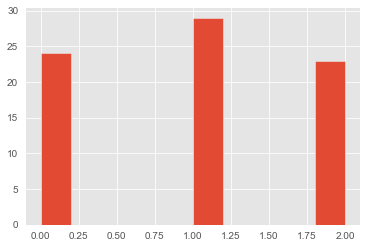

In [104]:
# Data set 2

sc2 = df_v[['BMDL_class', 'Substance', 'size_class', 'time', 'cell_type', 'assay','func',  'cell_species', 'media',
            'cell_type_general', 'species']].copy()

enc_size = {'S':1, 'M':2, 'L':3}
sc2.dropna(axis=0, inplace=True)
sc2.reset_index(drop=True, inplace=True)
# categorical variables encoding
sc2['size_class'] = sc2['size_class'].apply(lambda row: enc_size[row])
sc2 = pd.get_dummies(sc2, columns=['Substance',  'cell_type', 'cell_species', 'cell_type_general', 'species' , 'assay',
                                   'func', 'media'], drop_first=True)

y_big = sc2['BMDL_class']
x_source_big = sc2.drop(labels='BMDL_class', axis=1)

fig = plt.figure()
plt.hist(y_big)
plt.show()

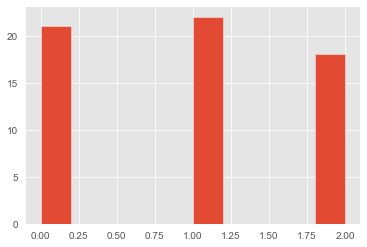

In [105]:
# Data set 3

sc3 = df_v[['BMDL_class', 'Substance', 'size_class', 'time', 'cell_type', 'assay','func',  'cell_species', 'media',
            'cell_type_general', 'species', 'layer']].copy()

enc_size = {'S':1, 'M':2, 'L':3}
sc3.dropna(axis=0, inplace=True)
sc3.reset_index(drop=True, inplace=True)
# categorical variables encoding
sc3['size_class'] = sc3['size_class'].apply(lambda row: enc_size[row])
sc3 = pd.get_dummies(sc3, columns=['Substance',  'cell_type', 'cell_species', 'cell_type_general', 'species' , 'assay',
                                   'func', 'media'], drop_first=True)

y_layer = sc3['BMDL_class']
x_source_l = sc3.drop(labels='BMDL_class', axis=1)

fig = plt.figure()
plt.hist(y_layer)
plt.show()

In [106]:
# Run this to select data set 1

y = y_1
x_source = x_source_1

In [148]:
# Run this to select data set 2

y = y_big
x_source = x_source_big

In [158]:
# Run this to select data set 3

y = y_layer
x_source = x_source_l

In [ ]:
##############################
# SVM classifier
#############################

In [159]:

# name to use in the figures to save to identify which data set is being used
x_name = 'x_3'

print(x_source.columns)
print(f'length dataset = {len(x_source)}')

Index(['size_class', 'time', 'layer', 'Substance_Graphene oxide',
       'Substance_rGO', 'cell_type_BEAS- 2B', 'cell_type_J774.A1',
       'cell_type_THP-1', 'cell_species_macrophage_human',
       'cell_species_macrophage_rodent', 'cell_type_general_macrophage',
       'species_rodent', 'assay_ez_cyto', 'assay_ldh', 'assay_mtt', 'assay_pi',
       'assay_wst', 'func_COOH', 'func_NH2', 'func_PAA', 'func_PAM',
       'func_PEG', 'func_hydrated', 'media_DMEM10FBS', 'media_DMEMF1210FBS',
       'media_F1210FBS', 'media_RPMI10FBS'],
      dtype='object')
length dataset = 61


In [160]:

# Find best tuning parameter on internal validation set with LOOCV and then test with the outer test set with LOOCV

matplotlib.style.use('ggplot')

loo = LeaveOneOut()
y_true = []
y_pred = []
y_prob = []
outer_results = list()

x_source2 = np.array(x_source)
#Nested cross validation with parameter tuning
for train_index, test_index in loo.split(x_source2):
    # split data
    X_train, X_test = x_source2[train_index], x_source2[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # model and test procedure
    pipe_svc = Pipeline([('scaler', MinMaxScaler()), ('SVC', SVC(kernel='linear',  class_weight='balanced', probability=True))])
    # define search space
    search_space = [{'SVC__C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}]
    # define search
    search = GridSearchCV(pipe_svc, search_space, cv=LeaveOneOut(),  refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    y_prob.append(best_model.predict_proba(X_test))
    y_true.extend(y_test)
    y_pred.extend(yhat)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

y_prob = np.concatenate(y_prob, axis=0)

>acc=0.000, est=0.700, cfg={'SVC__C': 10}
>acc=1.000, est=1.000, cfg={'SVC__C': 0.001}
>acc=1.000, est=1.000, cfg={'SVC__C': 0.001}
>acc=1.000, est=1.000, cfg={'SVC__C': 0.001}
>acc=1.000, est=1.000, cfg={'SVC__C': 0.001}
>acc=1.000, est=1.000, cfg={'SVC__C': 0.001}
>acc=1.000, est=0.683, cfg={'SVC__C': 1}
>acc=1.000, est=0.683, cfg={'SVC__C': 1}
>acc=1.000, est=0.683, cfg={'SVC__C': 1}
>acc=1.000, est=0.683, cfg={'SVC__C': 1}
>acc=1.000, est=1.000, cfg={'SVC__C': 0.001}
>acc=0.000, est=0.717, cfg={'SVC__C': 10}
>acc=0.000, est=0.700, cfg={'SVC__C': 10}
>acc=0.000, est=0.717, cfg={'SVC__C': 10}
>acc=0.000, est=0.733, cfg={'SVC__C': 10}
>acc=1.000, est=1.000, cfg={'SVC__C': 0.001}
>acc=1.000, est=1.000, cfg={'SVC__C': 0.001}
>acc=1.000, est=0.683, cfg={'SVC__C': 1}
>acc=1.000, est=0.683, cfg={'SVC__C': 1}
>acc=1.000, est=0.683, cfg={'SVC__C': 1}
>acc=1.000, est=0.683, cfg={'SVC__C': 1}
>acc=1.000, est=0.683, cfg={'SVC__C': 1}
>acc=0.000, est=0.717, cfg={'SVC__C': 1}
>acc=1.000, est=1.00

0.7049180327868853


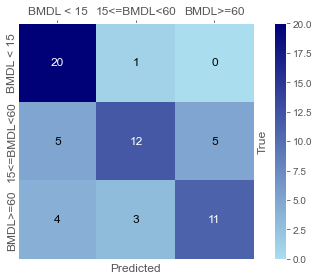

             precision    recall  f1-score  support  pred       AUC
0.0           0.689655  0.952381  0.800000     21.0  29.0  0.635714
1.0           0.750000  0.545455  0.631579     22.0  16.0  0.627040
2.0           0.687500  0.611111  0.647059     18.0  16.0  0.647287
avg / total   0.710783  0.704918  0.694128     61.0  61.0       NaN
specificity
specificity first row = 0.775
specificity second row = 0.8974358974358975
specificity third row = 0.8837209302325582


In [161]:
# Calculate performance metrics

# Accuracy score
accuracy_avg = metrics.accuracy_score(y_true, y_pred)
print(accuracy_avg)
# Confusion matrix
confusion = metrics.confusion_matrix(y_true, y_pred)
#tick_names = ['BMDL < 12', '12<=BMDL<25', '25<=BMDL<50', 'BMDL>=50']
tick_names = ['BMDL < 15', '15<=BMDL<60', 'BMDL>=60']

confusion_matrix(confusion, tick_names, 'Graphene//New_plots//SVC_confusion_matrix_3class', x_name )
# Multiple performance metrics
'''
recap = metrics.classification_report(y_true, y_pred, target_names=tick_names)
print(recap)
'''
y_true_auc = np.array(y_true)
y_pred_auc = np.array(y_pred)

report_with_auc = class_report(y_true_auc, y_pred_auc, y_prob, average='weighted')
print(report_with_auc)

print('specificity')
specificity(confusion)


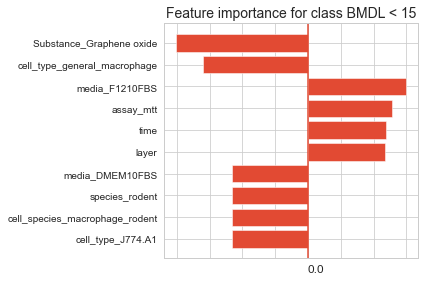

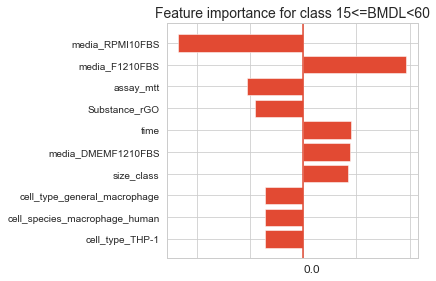

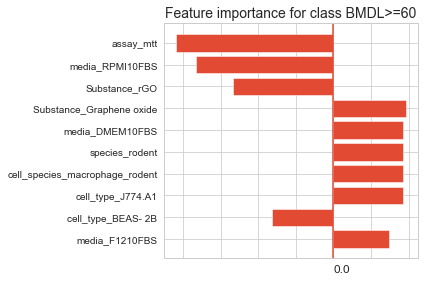

In [162]:
# print top 10 features of model fit on the whole data set
sns.set_style('whitegrid')

feature_names = [x for x in x_source.columns]
#class_names = ['BMDL < 12', '12<=BMDL<25', '25<=BMDL<50', 'BMDL>=50']
class_names = ['BMDL < 15', '15<=BMDL<60', 'BMDL>=60']

pipe_final = Pipeline([('scaler', MinMaxScaler()), ('SVC', SVC(kernel='linear',  class_weight='balanced', probability=True))])
# define search space
search_space = [{'SVC__C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}]
# define search
search = GridSearchCV(pipe_final, search_space, cv=LeaveOneOut(), scoring='accuracy', refit=True)
# execute search
result = search.fit(x_source, y)
# get the best performing model fit on the whole training set
best_model = result.best_estimator_

print_top10(feature_names, best_model.named_steps['SVC'], x_name, class_names)

In [ ]:
###############################
# Decision tree classifier
###############################

In [ ]:
# select data set - change accordingly




In [163]:
# Find best tuning parameter on internal validation set with LOOCV and then test with the outer test set with LOOCV

matplotlib.style.use('ggplot')

loo = LeaveOneOut()
y_true = []
y_pred = []
y_prob = []
outer_results = list()

x_source2 = np.array(x_source)
#Nested cross validation with parameter tuning
for train_index, test_index in loo.split(x_source2):
    # split data
    X_train, X_test = x_source2[train_index], x_source2[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # model and test procedure
    pipe_dt = Pipeline([('scaler', MinMaxScaler()), ('DT', DecisionTreeClassifier(class_weight='balanced'))])
    # define search space
    search_space = [{'DT__max_depth': [x for x in range(3,6)], 'DT__min_samples_split': [x for x in range(2, 6)]}]
    # define search
    search = GridSearchCV(pipe_dt, search_space, cv=LeaveOneOut(), scoring='accuracy', refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    y_prob.append(best_model.predict_proba(X_test))
    y_true.extend(y_test)
    y_pred.extend(yhat)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

y_prob = np.concatenate(y_prob, axis=0)


>acc=1.000, est=0.633, cfg={'DT__max_depth': 3, 'DT__min_samples_split': 2}
>acc=1.000, est=0.617, cfg={'DT__max_depth': 4, 'DT__min_samples_split': 2}
>acc=1.000, est=0.567, cfg={'DT__max_depth': 3, 'DT__min_samples_split': 2}
>acc=1.000, est=0.567, cfg={'DT__max_depth': 3, 'DT__min_samples_split': 2}
>acc=1.000, est=0.617, cfg={'DT__max_depth': 4, 'DT__min_samples_split': 2}
>acc=1.000, est=0.617, cfg={'DT__max_depth': 4, 'DT__min_samples_split': 2}
>acc=1.000, est=0.600, cfg={'DT__max_depth': 3, 'DT__min_samples_split': 3}
>acc=1.000, est=0.633, cfg={'DT__max_depth': 3, 'DT__min_samples_split': 3}
>acc=1.000, est=0.633, cfg={'DT__max_depth': 3, 'DT__min_samples_split': 2}
>acc=1.000, est=0.600, cfg={'DT__max_depth': 3, 'DT__min_samples_split': 4}
>acc=0.000, est=0.650, cfg={'DT__max_depth': 3, 'DT__min_samples_split': 2}
>acc=0.000, est=0.650, cfg={'DT__max_depth': 3, 'DT__min_samples_split': 2}
>acc=1.000, est=0.600, cfg={'DT__max_depth': 3, 'DT__min_samples_split': 2}
>acc=0.000, 

0.639344262295082


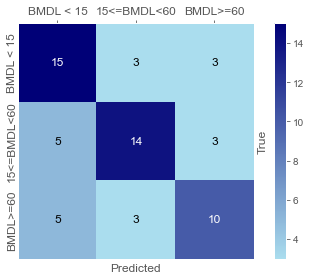

             precision    recall  f1-score  support  pred       AUC
0.0           0.600000  0.714286  0.652174     21.0  25.0  0.747619
1.0           0.700000  0.636364  0.666667     22.0  20.0  0.773893
2.0           0.625000  0.555556  0.588235     18.0  16.0  0.829457
avg / total   0.643443  0.639344  0.638534     61.0  61.0       NaN
specificity
specificity first row = 0.75
specificity second row = 0.8461538461538461
specificity third row = 0.8604651162790697


In [164]:
# Metrics
# Accuracy score
accuracy_avg = metrics.accuracy_score(y_true, y_pred)
print(accuracy_avg)
# Confusion matrix
confusion = metrics.confusion_matrix(y, y_pred)
#tick_names = ['BMDL < 12', '12<=BMDL<25', '25<=BMDL<50', 'BMDL>=50']
tick_names = ['BMDL < 15', '15<=BMDL<60', 'BMDL>=60']

confusion_matrix(confusion, tick_names, 'Graphene//New_plots//DT_confusion_matrix_3class', x_name )

# Multiple performance metrics

y_true_auc = np.array(y_true)
y_pred_auc = np.array(y_pred)

report_with_auc = class_report(y_true_auc, y_pred_auc, y_prob, average='weighted')
print(report_with_auc)


# Specificity
print('specificity')
specificity(confusion)

In [136]:
confusion[2,0]

6

In [165]:
# Fit on whole data set to find single tree
feature_names = [x for x in x_source.columns]
#class_names = ['BMDL < 12', '12<=BMDL<25', '25<=BMDL<50', 'BMDL>=50']
class_names = ['BMDL < 15', '15<=BMDL<60', 'BMDL>=60']

pipe_dt = Pipeline([('scaler', MinMaxScaler()), ('DT', DecisionTreeClassifier(class_weight='balanced'))])
# define search space
search_space = [{'DT__max_depth': [x for x in range(3,6)], 'DT__min_samples_split': [x for x in range(2, 6)]}]
# define search
search = GridSearchCV(pipe_dt, search_space, cv=LeaveOneOut(), scoring='accuracy', refit=True)
# execute search
tree_res = search.fit(x_source, y)
# get the best performing model fit on the whole training set
best_model = tree_res.best_estimator_

# Draw tree
feature_names = x_source.columns
dot_data = export_graphviz(best_model.named_steps['DT'], out_file=f'Graphene//New_plots//Decision_tree_classifier_3class_cat_15-60_balanced_{x_name}.dot',
            filled=True, rounded=True, feature_names=feature_names, class_names=['BMDL < 15', '15<=BMDL<60',  'BMDL>=60'])

render('dot', 'png', f'Graphene//New_plots//Decision_tree_classifier_3class_cat_15-60_balanced_{x_name}.dot')



'Graphene\\New_plots\\Decision_tree_classifier_3class_cat_15-60_balanced_x_3.dot.png'

In [ ]:
##############################
# Random Forest classifier
##############################

In [166]:
# Find best tuning parameter on internal validation set with LOOCV and then test with the outer test set with LOOCV

matplotlib.style.use('ggplot')

loo = LeaveOneOut()
y_true = []
y_pred = []
y_prob = []
outer_results = list()

x_source2 = np.array(x_source)
#Nested cross validation with parameter tuning
for train_index, test_index in loo.split(x_source2):
    # split data
    X_train, X_test = x_source2[train_index], x_source2[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # model and test procedure
    pipe_dt = Pipeline([('scaler', MinMaxScaler()), ('RF', RandomForestClassifier())])
    # define search space
    search_space = [{'RF__n_estimators': [10], 'RF__max_depth': [x for x in range(3,6)], 'RF__min_samples_split': [x for x in range(2, 6)]}]
    # define search
    search = GridSearchCV(pipe_dt, search_space, cv=LeaveOneOut(), scoring='accuracy', refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    y_prob.append(best_model.predict_proba(X_test))
    y_true.extend(y_test)
    y_pred.extend(yhat)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

y_prob = np.concatenate(y_prob, axis=0)


>acc=1.000, est=0.617, cfg={'RF__max_depth': 4, 'RF__min_samples_split': 2, 'RF__n_estimators': 10}
>acc=1.000, est=0.600, cfg={'RF__max_depth': 3, 'RF__min_samples_split': 4, 'RF__n_estimators': 10}
>acc=1.000, est=0.617, cfg={'RF__max_depth': 5, 'RF__min_samples_split': 4, 'RF__n_estimators': 10}
>acc=1.000, est=0.600, cfg={'RF__max_depth': 4, 'RF__min_samples_split': 3, 'RF__n_estimators': 10}
>acc=1.000, est=0.650, cfg={'RF__max_depth': 4, 'RF__min_samples_split': 3, 'RF__n_estimators': 10}
>acc=1.000, est=0.583, cfg={'RF__max_depth': 4, 'RF__min_samples_split': 2, 'RF__n_estimators': 10}
>acc=0.000, est=0.650, cfg={'RF__max_depth': 4, 'RF__min_samples_split': 2, 'RF__n_estimators': 10}
>acc=1.000, est=0.600, cfg={'RF__max_depth': 3, 'RF__min_samples_split': 5, 'RF__n_estimators': 10}
>acc=0.000, est=0.633, cfg={'RF__max_depth': 4, 'RF__min_samples_split': 2, 'RF__n_estimators': 10}
>acc=1.000, est=0.600, cfg={'RF__max_depth': 4, 'RF__min_samples_split': 3, 'RF__n_estimators': 10}


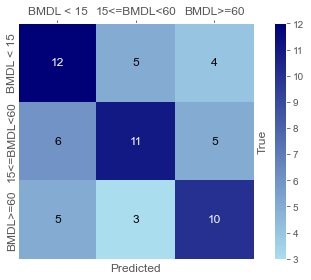

             precision    recall  f1-score  support  pred       AUC
0.0           0.521739  0.571429  0.545455     21.0  23.0  0.717857
1.0           0.578947  0.500000  0.536585     22.0  19.0  0.710956
2.0           0.526316  0.555556  0.540541     18.0  19.0  0.768734
avg / total   0.543722  0.540984  0.540806     61.0  61.0       NaN
specificity
specificity first row = 0.725
specificity second row = 0.7948717948717948
specificity third row = 0.7906976744186046


In [167]:
# METRICS
# Accuracy score
accuracy_avg = metrics.accuracy_score(y_true, y_pred)

# Confusion matrix
confusion = metrics.confusion_matrix(y, y_pred)
#tick_names = ['BMDL < 12', '12<=BMDL<25', '25<=BMDL<50', 'BMDL>=50']
tick_names = ['BMDL < 15', '15<=BMDL<60', 'BMDL>=60']

confusion_matrix(confusion, tick_names, 'Graphene//New_plots//RF_confusion_matrix_3class', x_name )
# Multiple performance metrics

y_true_auc = np.array(y_true)
y_pred_auc = np.array(y_pred)

report_with_auc = class_report(y_true_auc, y_pred_auc, y_prob, average='weighted')
print(report_with_auc)


# Specificity
print('specificity')
specificity(confusion)

